## 8.1 自编码网络的介绍及其应用

In [1]:
# 自编码网络是非监督学习领域的一种，可以自动从无标注的数据中学习特征
# 是一种以重构输入信号为目的的神经网络，它可以给出比原数据更好的特征描述
# 在深度学习中常用自编码网络生成的特征来取代原始数据，以得到更好的效果

# 8.2 最简单的自编码网络

In [2]:
# 自编码网络(Auto-Encoder, AE)网络最基本的模型可以视为三层的神经网络—输入层，隐藏层和输出层
# 输入层的样本也会充当输出层的标签角色
# 自编码神经网络是一种尽可能复现输入信号的神经网络

# 从输入到中间状态的过程称为编码，从中间状态到输出的过程称为解码
# 自编码器要求输出尽可能接近于输入，并且其隐藏层必须满足一定的稀疏性
# 可以通过将隐藏层中的后一层神经元个数比前一层少的方式来实现稀疏效果

# 相当于隐藏层对输入进行了压缩，并在输出层进行了解压
# 整个过程肯定会丢失信息，但训练过程能够使丢失信息尽量减少，最大化保留其主要特征

## 8.3 自编码网络的代码实现

### 8.3.1 提取图片特征，并利用特征还原图片

In [3]:
# 通过构建一个两层降维的自编码网络，将MNIST数据集的特征提取出来，并通过这些特征再重建一个MNIST数据集

# 引入头文件，并加载数据集
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

# 定义网路模型
# 输入MNIST数据集的图片，将其像素点组成的数据(28X28=784)从784降维到256，然后再降到128
# 然后以相反的方式从128，256，到784进行还原


n_input = 784 # MNIST数据集中图片的维度
n_hidden_1 = 256 # 第一层256个节点
n_hidden_2 = 128 # 第二层128个节点

# 占位符
x = tf.placeholder('float', [None, n_input]) # 输入
y = x # 输出

# 学习参数
weights = {
    'encoder_h1':tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2':tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1':tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2':tf.Variable(tf.random_normal([n_hidden_1, n_input]))}

biases = {
    'encoder_b1':tf.Variable(tf.zeros([n_hidden_1])),
    'encoder_b2':tf.Variable(tf.zeros([n_hidden_2])),
    'decoder_b1':tf.Variable(tf.zeros([n_hidden_1])),
    'decoder_b2':tf.Variable(tf.zeros([n_input]))}

# 编码
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2
# 解码
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2
    
#  输出的节点
encoder_out = encoder(x)
pred = decoder(encoder_out)

#  cost为y与pred的平方差
learning_rate = 0.01
cost = tf.reduce_mean(tf.pow(y-pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# 开始训练
# 训练参数
training_epochs = 20 # 一共迭代20次
batch_size = 256 # 一次处理256个样本
display_step = 5 # 每迭代5次输出一次信息

# 启动会话
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(mnist.train.num_examples/batch_size)
    # 开始训练
    for epoch in range(training_epochs):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size) # 取数据
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs})
            # 训练模型
        if epoch % display_step == 0: # 显示日志信息
            print('Epoch:{}'.format(epoch+1), 'cost={:.9f}'.format(c))
    print('Finished!')

# 测试模型

    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
# 计算准确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    print('Accuracy:{}'.format(accuracy))

# 双比输入和输出
    show_num = 10
    reconstruction = sess.run(pred, feed_dict={x:mnist.test.images[: show_num]})
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range (show_num):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28, 28)))
        a[1][i].imshow(np.reshape(reconstruction[i], (28, 28)))
    plt.draw()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Colocations handled automatically by placer.
Epoch:1 cost=0.196941435
Epoch:6 cost=0.122502774
Epoch:11 cost=0.108083114
Epoch:16 cost=0.101322077
Finished!
Accuracy:Tensor("Mean_1:0", shape=(), dtype=float32)


### 8.3.2 线性解码器

In [4]:
# 使用sigmoid函数作为激活函数时，输出范围是[0, 1],相当于对提取的特征节点进行范围压缩
# 由多个带有S型激活函数的隐含层以及一个线性输出层构成的编码器，称为线性编码器

### 8.3.3 提取图片的二维特征，并利用二位特征还原图片

In [5]:
# 在自编码网络中使用线性解码器对MNIST数据特征进行再压缩，并将其映射到直角坐标系上
# 使用4层逐渐将784维度分别压缩成256，64，16，2这4个特征向量
# 然后以直角坐标系的形式将数据点显示出来，这样可以直观地看到自编码器对同一类图片的聚类效果

# 引入头文件，定义学习参数变量
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 导入MNIST数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

n_input=784
# 隐藏层设置
n_hidden_1=256
n_hidden_2=64
n_hidden_3=16
n_hidden_4=2

# 定义输入占位符
x = tf.placeholder('float', shape=[None, n_input])
y=x

# 定义训练参数
weights={
    'encoder_h1':tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2':tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3':tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'encoder_h4':tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    
    'decoder_h1':tf.Variable(tf.random_normal([n_hidden_4, n_hidden_3])),
    'decoder_h2':tf.Variable(tf.random_normal([n_hidden_3, n_hidden_2])),
    'decoder_h3':tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h4':tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}

biases={
    'encoder_b1':tf.Variable(tf.zeros([n_hidden_1])),
    'encoder_b2':tf.Variable(tf.zeros([n_hidden_2])),
    'encoder_b3':tf.Variable(tf.zeros([n_hidden_3])),
    'encoder_b4':tf.Variable(tf.zeros([n_hidden_4])),
    
    'decoder_b1':tf.Variable(tf.zeros([n_hidden_3])),
    'decoder_b2':tf.Variable(tf.zeros([n_hidden_2])),
    'decoder_b3':tf.Variable(tf.zeros([n_hidden_1])),
    'decoder_b4':tf.Variable(tf.zeros([n_input])),
}

# 定义网络模型
# 这里使用了线性解码器，在编码的最后一层没有进行sigmoid变换
# 这是因为生产的二维数据的数据特征已经变得十分重要，所以我们希望让它透传到解码器中
# 少一些变换可以最大化保存原有的主要特征

# 构建反向模型
def encoder(x):
    layer1=tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer2=tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['encoder_h2']), biases['encoder_b2']))
    layer3=tf.nn.sigmoid(tf.add(tf.matmul(layer2, weights['encoder_h3']), biases['encoder_b3']))
    # encoder的最后一层没有进行sigmoid变换
    layer4=tf.add(tf.matmul(layer3, weights['encoder_h4']), biases['encoder_b4']) 
    return layer4
def decoder(x):
    layer1=tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer2=tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['decoder_h2']), biases['decoder_b2']))
    layer3=tf.nn.sigmoid(tf.add(tf.matmul(layer2, weights['decoder_h3']), biases['decoder_b3']))
    layer4=tf.nn.sigmoid(tf.add(tf.matmul(layer3, weights['decoder_h4']), biases['decoder_b4']))
    return layer4

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Epoch:1 cost=0.11238132417201996
Epoch:2 cost=0.09267470240592957
Epoch:3 cost=0.08172810077667236
Epoch:4 cost=0.07795581221580505
Epoch:5 cost=0.07627430558204651
Epoch:6 cost=0.06924492120742798
Epoch:7 cost=0.06765270978212357
Epoch:8 cost=0.06733596324920654
Epoch:9 cost=0.06759776175022125
Epoch:10 cost=0.0640973374247551
Epoch:11 cost=0.0634847953915596
Epoch:12 cost=0.06322628259658813
Epoch:13 cost=0.06216110661625862
Epoch:14 cost=0.06032159551978111
Epoch:15 cost=0.06024324148893356
Epoch:16 cost=0.062175001949071884
Epoch:17 cost=0.05811949819326401
Epoch:18 cost=0.06040067970752716
Epoch:19 cost=0.05616801977157593
Epoch:20 cost=0.055833227932453156
Finished!


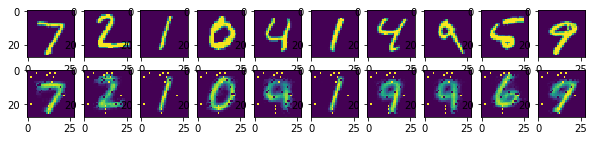

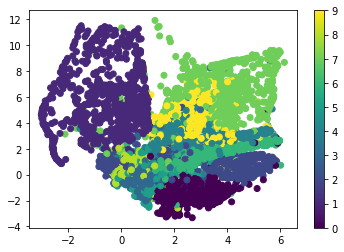

In [6]:
# 构建反向模型
encoder_op = encoder(x)
y_pred = decoder(encoder_op)
 
learning_rate = 0.01
cost = tf.reduce_mean(tf.pow(y-y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# 开始训练

training_epochs = 20
batch_size = 256
display_step = 1

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(mnist.train.num_examples/batch_size)
    
    # 启动循环开始训练
    for epoch in range(training_epochs):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c = sess.run([optimizer, cost], feed_dict={x:batch_xs})
        
        # 显示训练中测信息
        if epoch % display_step ==0:
            print('Epoch:{}'.format(epoch+1), 'cost={}'.format(c))
    print('Finished!')
    
    # 对比输入和输出
    show_num = 10
    encode_decode=sess.run(y_pred, feed_dict={x:mnist.test.images[:show_num]})
    # 显示自编码结果和原始样本的结果
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(show_num):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    plt.show()
    
    # 显示数据被压缩到二维的特征
    aa = [np.argmax(l) for l in mnist.test.labels] # 将one_hot
    encoder_result = sess.run(encoder_op, feed_dict={x:mnist.test.images})
    plt.scatter(encoder_result[:, 0], encoder_result[:, 1], c=aa) 
    plt.colorbar()
    plt.show()

## 8.4 去噪自编码

In [7]:
# 在自动编码的基础上，训练数据加入噪声，输出的标签仍然是原始的未添加噪声的样本
# 这样可以迫使自动编码器去学习输入信号中更加鲁棒的特征表达

## 8.5 去噪自编码网络的代码实现

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Start!
Epoch:0,average cost=0.11092317525610745
Epoch:2,average cost=0.06411647737444004
Epoch:4,average cost=0.05173999732621362
Epoch:6,average cost=0.04208765319922817
Epoch:8,average cost=0.034589149919556125
Epoch:10,average cost=0.029900006262289586
Epoch:12,average cost=0.02696879988832173
Epoch:14,average cost=0.025213856371902973
Epoch:16,average cost=0.024085036217818195
Epoch:18,average cost=0.023258274847589362
Finish!


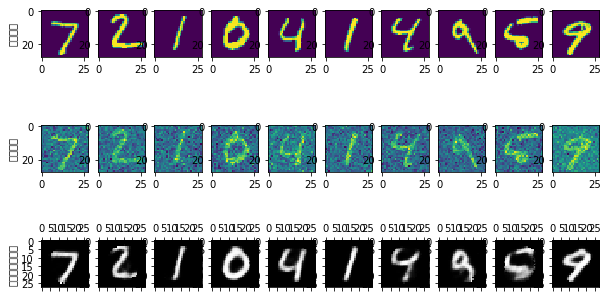

Label is [2]
Salt and Pepper Noise


NameError: name 'noiseidx' is not defined

In [8]:
# 对MNIST集原始输入加入噪声，在自编码网络中进行训练，以得到抗干扰更强的特征提取模型
# 让784维只通过一层压缩成256维
# 将原始的数据进行变换，每个像素点都乘以一个高斯噪声，然后输出的标签仍然使用原始的输入样本
# 这样可以迫使网络在提取特征时将噪声去掉
# 为了防止过拟合，还需要在其中加入Dropout层


# 引入头文件，定义学习参数变量，创建网络模型
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
train_x = mnist.train.images
train_y = mnist.train.labels
test_x = mnist.test.images
test_y = mnist.test.labels

n_input = 784
n_hidden_1 = 256

# 定义占位符
x = tf.placeholder('float', shape=[None, n_input])
y = tf.placeholder('float', shape=[None, n_input])
drop_keep_prob = tf.placeholder('float')

# 学习参数
weights = {
    'h1':tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2':tf.Variable(tf.random_normal([n_hidden_1, n_hidden_1])),
    'out':tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}

biases = {
    'b1':tf.Variable(tf.zeros([n_hidden_1])),
    'b2':tf.Variable(tf.zeros([n_hidden_1])),
    'out':tf.Variable(tf.zeros([n_input]))
}

# 网络模型
def denoise_auto_encoder(_x, _weights, _biases, _keep_prob):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_x, _weights['h1']), _biases['b1']))
    layer_1_out = tf.nn.dropout(layer_1, _keep_prob)
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1_out, _weights['h2']), _biases['b2']))
    layer_2_out = tf.nn.dropout(layer_2, _keep_prob)
    return tf.nn.sigmoid(tf.matmul(layer_2_out, _weights['out']) + _biases['out'])

reconstruction = denoise_auto_encoder(x, weights, biases, drop_keep_prob)

# cost计算
cost = tf.reduce_mean(tf.pow(reconstruction - y, 2))

# 优化器
optm = tf.train.AdamOptimizer(0.01).minimize(cost)


# 设置训练参数 开始训练
epochs = 20
batch_size = 256
disp_step = 2

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Start!')
    for epoch in range(epochs):
        num_batch = int(mnist.train.num_examples/batch_size)
        total_cost=0
        for i in range(num_batch):
            # 生成噪声数据
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            batch_xs_noisy = batch_xs + 0.3*np.random.randn(batch_size, 784)
            feeds = {x:batch_xs_noisy, y: batch_xs, drop_keep_prob:0.8}
            sess.run(optm, feed_dict=feeds)
            total_cost += sess.run(cost, feed_dict=feeds)
            
        # 显示训练日志
        if epoch % disp_step == 0:
            print('Epoch:{},average cost={}'.format(epoch, total_cost/num_batch))
    print('Finish!')
    
    # 数据可视化
    show_num = 10
    test_noisy = mnist.test.images[: show_num]+0.3*np.random.randn(show_num, 784)
    encode_decode=sess.run(reconstruction, feed_dict={x:test_noisy, drop_keep_prob:1})
    f,a = plt.subplots(3, 10, figsize=(10, 6))
    for i in range(show_num):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(test_noisy[i], (28, 28)))
        a[2][i].matshow(np.reshape(encode_decode[i], (28,28)), cmap=plt.get_cmap('gray'))
    a[0][0].set_ylabel('原始数据')
    a[1][0].set_ylabel('添加噪声')
    a[2][0].set_ylabel('去噪自编码结果')
    plt.show()
    
   # 测试鲁棒性
    randidx = np.random.randint(test_x.shape[0], size=1)
    orgvec = test_x[randidx, :]
    testvec = test_x[randidx, :]
    label = np.argmax(test_y[randidx, :], 1)
    print('Label is {}'.format(label))
    
    # 噪声类型
    print('Salt and Pepper Noise')
    noisyvec = testvec
    rate = 0.15
    noisyidx = np.random.randint(test_x.shape[1], size=int(test_x.shape[1]*rate))
    noisyvec[0, noisyidx] = 1-noisyvec[0, noiseidx]
    outvec = sess.run(reconstruction, feed_dict={x:noisyvec, drop_keep_prob:0.8})
    outimg = np.reshape(outvec, (28, 28))
    
    # 可视化
    plt.matshow(np.reshape(orgvec, (28, 28)), cmap=plt.get_cmap('gray'))
    plt.title('Original Image')
    plt.colorbar()
    
    plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
    plt.title('Input Image')
    plt.colorbar()
    
    plt.matshow(np.reshape(outimg, (28, 28)), cmap=plt.get_cmap('gray'))
    plt.title('Reconstructed Image')
    plt.colorbar()
    plt.show()

## 8.9 变分自编码器

### 8.9.1 什么是变分自编码

In [ ]:
# 变分自编码器学习的不再是样本的个体，而是学习样本的规律
# 这样训练出来的自编码不但具有重构样本的功能，还有仿照样本的功能

### 8.9.2 使用变分自编码模拟生成MNIST数据

In [14]:
# 引入库，定义占位符
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/')

n_input = 784
n_hidden_1 = 256
n_hidden_2 = 2

# x表示原始图片数据的输入，z表示中间节点解码器的输入
x = tf.placeholder(tf.float32, [None, n_input])

z_input = tf.placeholder(tf.float32, [None, n_hidden_2])

# 定义学习参数
# mean_w1与mean_b1是生成mean的权重
# log_sigma_w1与log_sigma_b1是生成log_sigma的权重
weights = {'w1':tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=0.001)),
           'b1':tf.Variable(tf.zeros([n_hidden_1])),
           'mean_w1':tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.001)),
           'log_sigma_w1':tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.001)),
           'w2':tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev=0.001)),
           'b2':tf.Variable(tf.zeros([n_hidden_1])),
           'w3':tf.Variable(tf.truncated_normal([n_hidden_1, n_input], stddev=0.001)),
           'b3':tf.Variable(tf.zeros([n_input])),
           'mean_b1':tf.Variable(tf.zeros([n_hidden_2])),
           'log_sigma_b1':tf.Variable(tf.zeros([n_hidden_2]))
          }

# 定义网络结构
# 在变分自编码器中为训练的中间节点代表均值和方差，并将它们所代表的数据集向着标准高斯分布数据集靠近
# 即原始数据是样本，高斯分布数据是标签
# 然后用KL散度公式来计算它所代表的集合与标准的高斯分布集合间的距离，将这个距离作为误差，让它最小化而优化网络参数
# 其中的方差节点并不是真正意义上的方差，是取了log之后的
# 所以后续需要tf.exp（z_log_sigma_sq)的变换来取得方差的值，再通过tf.sqrt将其开平方得到标准差
# 用符合标准正态分布的一个数乘以标准差加上均值就可以使得这个数成为符合(z_mean, sigma)数据分布集合里的一个点
# z_mean是指网络生成的均值，sigma是指网络生成的z_log_simga_sq变换后的值

h1 = tf.nn.relu(tf.add(tf.matmul(x, weights['w1']),weights['b1']) )
z_mean = tf.add(tf.matmul(h1, weights['mean_w1']), weights['mean_b1'])
z_log_sigma_sq = tf.add(tf.matmul(h1,weights['log_sigma_w1']), weights['log_sigma_b1'])

# 高斯分布样本
eps = tf.random_normal(tf.stack([tf.shape(h1)[0], n_hidden_2]), 0, 1, dtype=tf.float32)
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
h2 = tf.nn.relu(tf.matmul(z, weights['w2'])+weights['b2'])
reconstruction = tf.matmul(h2, weights['w3']+weights['b3'])

h2_out = tf.nn.relu(tf.matmul(z_input, weights['w2'])+weights['b2'])
reconstructionout = tf.matmul(h2_out, weights['w3'])+weights['b3']

# 构建模型的反向传播

# 计算重建loss
reconstr_loss = 0.5 * tf.reduce_mean(tf.pow(tf.subtract(reconstruction, x), 2.0))
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq 
                                   - tf.square(z_mean) 
                                   - tf.exp(z_log_sigma_sq), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)

# 设置参数，开始训练

training_epochs = 50
batch_size = 128
display_step = 3

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _,c = sess.run([optimizer,cost],feed_dict={x:batch_xs})
            
        if epoch % display_step == 0:
            print('Epoch:{}, cost={}'.format(epoch+1, c))
    print('Finished!')
    
    # 测试 
    print('Result:', cost.eval({x:mnist.test.images}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch:1, cost=0.03369879722595215
Epoch:4, cost=0.03433818370103836
Epoch:7, cost=0.03482470288872719
Epoch:10, cost=0.035159409046173096
Epoch:13, cost=0.03377392888069153
Epoch:16, cost=0.03330092877149582
Epoch:19, cost=0.033380694687366486
Epoch:22, cost=0.033682312816381454
Epoch:25, cost=0.0333428718149662
Epoch:28, cost=0.032845914363861084
Epoch:31, cost=0.03338126093149185
Epoch:34, cost=0.033692777156829834
Epoch:37, cost=0.0340331494808197
Epoch:40, cost=0.034849490970373154
Epoch:43, cost=0.03299564868211746
Epoch:46, cost=0.0340762659907341
Epoch:49, cost=0.035476863384246826
Finished!
Result: 0.03379318
